1. 원본 Random Forest 모델

* 저번 주차에서 RMSE가 가장 낮고 R²가 가장 높은 모델은 Random Forest 모델

* 이 프로젝트는 회귀 모델이기 때문에 Accuracy, F1-score, AUC는 사용할 수 없어서 RMSE와 R²로 평가

* Accuracy는 정답 클래스와 예측 클래스가 정확히 같은가를 본다. 회귀의 예측값은 연속값(실수)이라 정확히 같은 경우가 거의 없어 Accuracy가 0에 근접하거나, 임의로 반올림/이산화하면 정보 손실이 일어남

* Precision / Recall / F1-score는 TP/FP/FN을 기반으로 한 지표라 라벨이 이진(또는 다중 고정 클래스)일 때만 의미가 있다. 연속값을 그대로 쓰면 정의 불가함

* AUC (ROC AUC)는 확률 점수와 이진 레이블(또는 다중-이진 변환)이 필요하다. 연속 타깃에선 레이블이 없으니 성립하지 않는다.

* 따라서 분류 지표들은 이산(카테고리) 정답을 전제로 설계됐기 때문에 연속 레이블인 회귀 문제에는 부적합함

In [43]:
import pandas as pd
import numpy as np
#import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor

# 데이터 읽기
df = pd.read_csv("dataset/winequality-red.csv")
df_eng = df.copy()
X = df.drop("quality", axis=1).values
y = df["quality"].values

# train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

np.random.seed(42)
#tf.random.set_seed(42)

# 표준화
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 초기 Random Forest (초기 하이퍼파라미터: n_estimators=100, random_state=42)
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# 예측 및 평가
y_pred_rf = rf_model.predict(X_test)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

print("=== Initial Random Forest ===")
print(f"RMSE: {rmse_rf:.4f}, R2: {r2_rf:.4f}")


=== Initial Random Forest ===
RMSE: 0.5483, R2: 0.5399


2. Random Forest 모델이 무엇을 학습했는지

* Feature Importance의 경우 모델이 중요하게 생각하는 특성을 찾아 어떤 변수가 품질 예측에 가장 영향을 주는지 순위를 뽑음
* 잘못된 변수가 높은 중요도를 가진다면 데이터 문제 발견 가능
* 내장 중요도(feature importances)는 각 트리에서 분할에 사용된 노드의 기준(정보 이득이나 불순도 감소)을 누적한 값으로, 빠르게 얻을 수 있지만 상관관계(collinearity)에 민감하고, 분포(범위)가 큰 변수에 유리하게 나오는 경향이 있음
* 가장 중요한 변수 = alcohol로, 내장 중요도 및 permutation 중요도가 가장 큼
* 그 다음으로 영향이 큰 변수들은 sulphates, volatile acidity

* Permutation Importance의 경우 변수를 랜덤으로 섞었을 때 성능이 얼마나 떨어지는지 측정해 변수의 실제 예측 기여도를 확인함
* Random Forest 내장 중요도는 편향이 있어서 신뢰도가 낮을 수 있으므로 사용
* Permutation 중요도는 검증(또는 테스트) 데이터에서 해당 feature의 값을 섞어(permutation) 모델 성능(여기선 디폴트 스코어, 회귀는 R²)에 얼마나 타격을 주는지 평균적으로 측정함
* 따라서 모델 성능 관점에서 실제로 기여하는 정도를 더 잘 반영함

* Partial Dependence Plot의 경우 특정 Feature가 증가하면 예측값(quality)이 어떻게 변하는지 시각화해 특성과 target 사이의 관계를 이해하는 그래프
* 모델의 의사결정 과정을 사람 눈으로 확인할 수 있음
* fixed acidity(왼쪽 PDP(부분 의존도))의 경우 표준화된 값 범위에서 약간 상승하는 추세인데, fixed acidity가 증가하면 예측 품질이 소폭 증가(하지만 변화 폭 작음)
* volatile acidity(오른쪽 PDP(부분 의존도))의 경우 값이 커질수록 예측 품질이 명확하고 꾸준히 감소하는 추세인데, volatile acidity는 품질에 강한 음(−)의 영향

                 feature  importance
0                alcohol    0.270868
1              sulphates    0.148406
2       volatile acidity    0.111547
3   total sulfur dioxide    0.076786
4              chlorides    0.071132
5                     pH    0.061418
6         residual sugar    0.057892
7          fixed acidity    0.053186
8                density    0.050816
9            citric acid    0.050752
10   free sulfur dioxide    0.047197


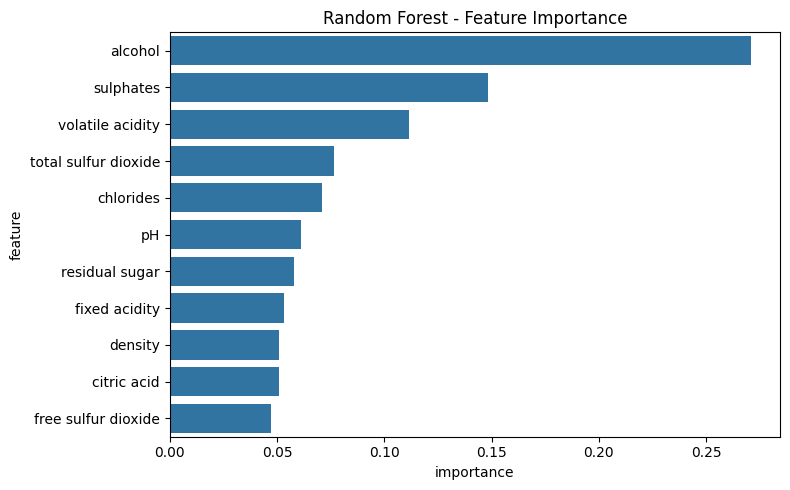

                 feature  perm_importance_mean
10               alcohol              0.414625
9              sulphates              0.241567
1       volatile acidity              0.148450
6   total sulfur dioxide              0.072086
8                     pH              0.032950
0          fixed acidity              0.028989
7                density              0.023582
5    free sulfur dioxide              0.022417
4              chlorides              0.021342
3         residual sugar              0.017795
2            citric acid              0.014742
PDP를 그릴 상위 2개 중요 피처: ['alcohol', 'sulphates']


<Figure size 1000x500 with 0 Axes>

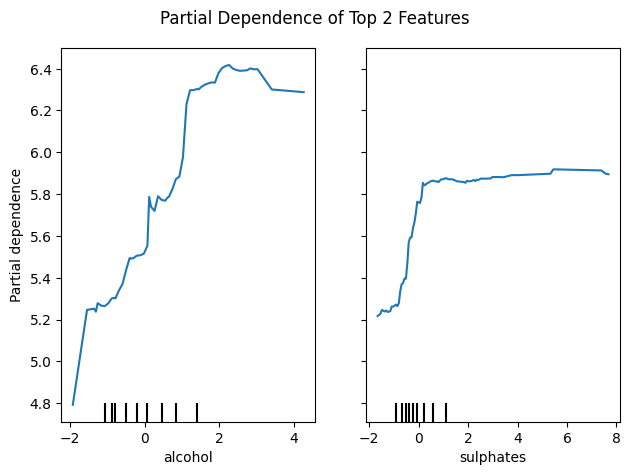

In [44]:
# 내장 Feature Importance
feature_names = df.drop("quality", axis=1).columns
#feature_names = pd.read_csv("dataset/winequality-red.csv").drop("quality", axis=1).columns
importances = rf_model.feature_importances_
importance_df = pd.DataFrame({"feature": feature_names, "importance": importances})
importance_df = importance_df.sort_values("importance", ascending=False).reset_index(drop=True)
print(importance_df)

# 시각화 (bar)
plt.figure(figsize=(8,5))
sns.barplot(x="importance", y="feature", data=importance_df)
plt.title("Random Forest - Feature Importance")
plt.tight_layout()
plt.show()

# Permutation Importance (보다 신뢰도 높은 중요도)
from sklearn.inspection import permutation_importance
perm_res = permutation_importance(rf_model, X_test, y_test, n_repeats=30, random_state=42, n_jobs=-1)
perm_df = pd.DataFrame({"feature": feature_names, "perm_importance_mean": perm_res.importances_mean})
perm_df = perm_df.sort_values("perm_importance_mean", ascending=False)
print(perm_df)

# Partial Dependence Plot
from sklearn.inspection import PartialDependenceDisplay
# 중요도 상위 2개 피처 이름 추출
top_2_features = importance_df["feature"].iloc[:2].tolist()
print(f"PDP를 그릴 상위 2개 중요 피처: {top_2_features}")

# 시각화
plt.figure(figsize=(10, 5))
PartialDependenceDisplay.from_estimator(
    rf_model, 
    X_train, 
    features=top_2_features, # [0, 1] 대신 변수 이름을 직접 넣습니다.
    feature_names=feature_names, # X_train이 numpy 배열이라도 이름을 매핑해줍니다.
    kind='average'
)
plt.suptitle("Partial Dependence of Top 2 Features")
plt.tight_layout()
plt.show()

3. 예측 성능과 잔차 진단

* 실제값(y_test)에서 예측값(y_pred_rf)을 빼서 잔차(오차)를 계산
* 잔차 분포 히스토그램을 통해 잔차가 정규분포(또는 대칭)에 가깝게 분포하는지, 편향(bias)이 있는지, 이상치가 있는지 확인
* 잔차 분포 히스토그램이 중앙(0) 근처에 몰려 있으면 편향이 적다는 신호. 만약 꼬리가 비대하거나 한쪽으로 치우치면 편향 존재하다는 뜻
* 결과 이미지는 대체로 정규에 가까운 모양이지만 약간의 꼬리·이상치가 존재함

* 예측값 잔차산점도 그래프의 경우 잔차가 예측값에 따라 패턴(예: 분산이 달라짐, 계통적 편향)을 보이는지 확인, 빨간 실선은 잔차 0 기준선
* 잔차가 예측값에 따라 무작위로 흩어지지 않고 패턴(대각선 형태의 띠)이 보이면 예측값 구간마다 체계적 오차(바이어스)가 있음(예: 특정 예측 구간에서 지속적으로 과대/과소 예측)
* 대각선/띠 패턴은 y_test의 값이 정수(3,4,5...)로 한정되어 있고, 예측값은 어느 범위에 묶여 나오기 때문에 생기는 구조적 현상일 수도 있음(예: 모델이 실제 정수 레이블을 일정 구간으로만 예측하는 경우)

* 실제값 예측 산점도 그래프의 경우 이상적인 경우 점들이 빨간 대각선 근처에 모임. 대각선 위로 올라가면 과예측, 아래면 과소예측
* 점들이 y=x 근처에 모이면 잘 맞춤. 하지만 넓게 퍼져있거나 특정 레이블에서 멀리 떨어진 점들이 많으면 그 레이블에서 오류 큼
* 그림에서 점들이 대체로 모여있지만 4,8 같은 값 주변에서 예측이 분포가 넓은 것으로 보이면 앞서 수치와 일치

* 각 quality (3,4,5,6,7,8) 별로 RMSE와 MAE를 계산해, 클래스별(품질별)로 모델의 성능을 비교함
* quality=5 (count=130): RMSE=0.4263, MAE=0.3206
: 이 클래스에 대해 모델이 가장 잘 맞추고 있음. 평균적으로 약 0.32 정도 차이나며(절대값 평균), 표준편차(혹은 큰 오차 감안)는 대략 0.43 수준
* quality=6 (count=132): RMSE=0.4505, MAE=0.3706
: 5와 유사하게 잘 맞음. 약간 오차가 더 큼
* quality=7 (count=42): RMSE=0.6428, MAE=0.5717
: 오차가 좀 더 커짐. 샘플 수도 7에서 줄어들어(42) 성능 저하 가능
* quality=4 (count=10): RMSE=1.1941, MAE=1.1500
: 오차가 큼. 샘플 수가 적어(10) 모델이 잘 학습 못했을 가능성
* quality=3 (count=1): RMSE=2.27 (한 샘플)
: 표본이 1개라서 이 값은 통계적으로 신뢰할 수 없음. 이 하나의 케이스가 크게 틀려서 RMSE가 큼
* quality=8 (count=5): RMSE=1.3433, MAE=1.33
: 최상위 클래스(8)도 샘플이 적고 에러가 큽니다. 모델이 희소한 레이블에 대해 약함
* 요약하자면 중간값(5,6)에 대해서는 예측이 비교적 정확하고, 샘플 수가 적은 극단(3,4,8)에 대해서는 오차가 크게 나타남. 이는 데이터 불균형(클래스 불균형)과 각 클래스별 학습 불충분을 시사함

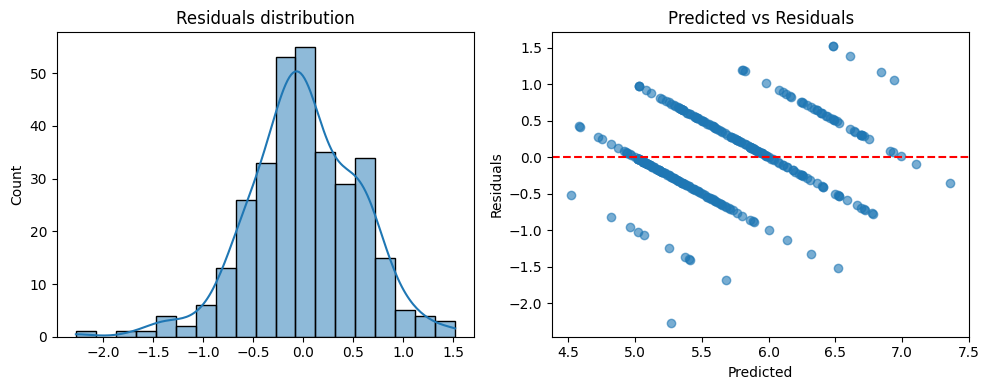

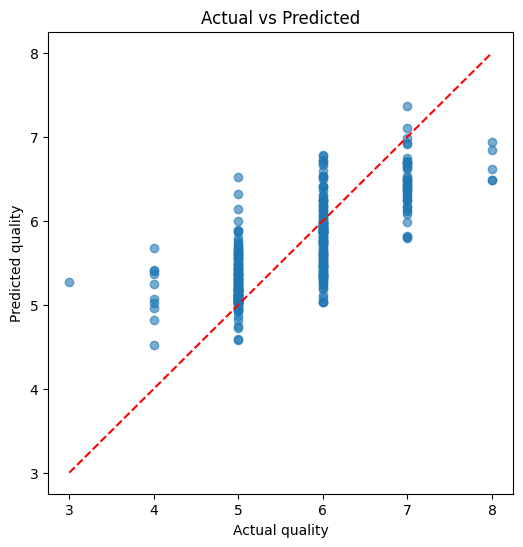

quality=3: count=1, RMSE=2.2700, MAE=2.2700
quality=4: count=10, RMSE=1.1941, MAE=1.1500
quality=5: count=130, RMSE=0.4263, MAE=0.3206
quality=6: count=132, RMSE=0.4505, MAE=0.3706
quality=7: count=42, RMSE=0.6428, MAE=0.5717
quality=8: count=5, RMSE=1.3433, MAE=1.3300


In [45]:
# 잔차 분석
residuals = y_test - y_pred_rf

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
sns.histplot(residuals, kde=True)
plt.title("Residuals distribution")

plt.subplot(1,2,2)
plt.scatter(y_pred_rf, residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.title("Predicted vs Residuals")
plt.tight_layout()
plt.show()

# 예측 vs 실제
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_rf, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual quality")
plt.ylabel("Predicted quality")
plt.title("Actual vs Predicted")
plt.show()

# 클래스별(quality 별) RMSE/MAE 확인
import numpy as np
from sklearn.metrics import mean_absolute_error

unique_q = np.unique(y_test)
for q in unique_q:
    idx = y_test == q
    if idx.sum() == 0:
        continue
    rmse_q = np.sqrt(mean_squared_error(y_test[idx], y_pred_rf[idx]))
    mae_q = mean_absolute_error(y_test[idx], y_pred_rf[idx])
    print(f"quality={q}: count={idx.sum()}, RMSE={rmse_q:.4f}, MAE={mae_q:.4f}")


4. 성능 개선
* Feature Engineering (파생 변수 추가 + 중요 피처 제거)
* alcohol_to_volatile은 알코올/휘발산 함량 비율
    * 기존 alcohol과 volatile acidity 정보를 결합해, 개별 피처보다 품질 예측에 더 유용한 지표 생성
* sulfur_ratio는 총 아황산/유리 아황산 비율
    * 아황산 관련 정보 결합으로 품질과의 관계를 더 명확히 함
* 불필요한 컬럼 제거 (citric acid, residual sugar, free sulfur dioxide)
    * 모델 복잡도 감소, 잡음 제거, 학습 안정성 향상

* 클래스 불균형 처리 (샘플 가중치)
* 데이터셋에서 품질 3, 4, 8 같이 극단값 샘플이 적어 일반 RMSE 기준 학습 시 학습이 소홀
* sample_weights를 통해 희소 샘플을 강조
* 랜덤포레스트가 극단값 품질 예측에도 조금 더 신경 쓰도록 함

* Random Forest 하이퍼파라미터 튜닝
* n_estimators=1000을 통해 트리 수 증가, 안정적 예측
* max_depth=15을 통해 트리 깊이 확장, 복잡한 피처 상호작용 학습 가능
* min_samples_leaf=2을 통해 극단값 샘플이 너무 작은 리프에서 과적합 방지
* max_features='sqrt'을 통해 각 분할 시 랜덤 피처 선택, 편향-분산 균형 개선

* 성능 개선폭은 크지 않지만, 모델이 극단값과 일반값 모두를 조금 더 균형 있게 학습하도록 조정됨

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
최적의 파라미터: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}
Best CV Score (Negative MSE): -1.3299
RMSE: 0.5723, R2: 0.4987


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_50860\2716917607.py:87: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="importance", y="feature", data=importance_df_eng, palette="viridis")


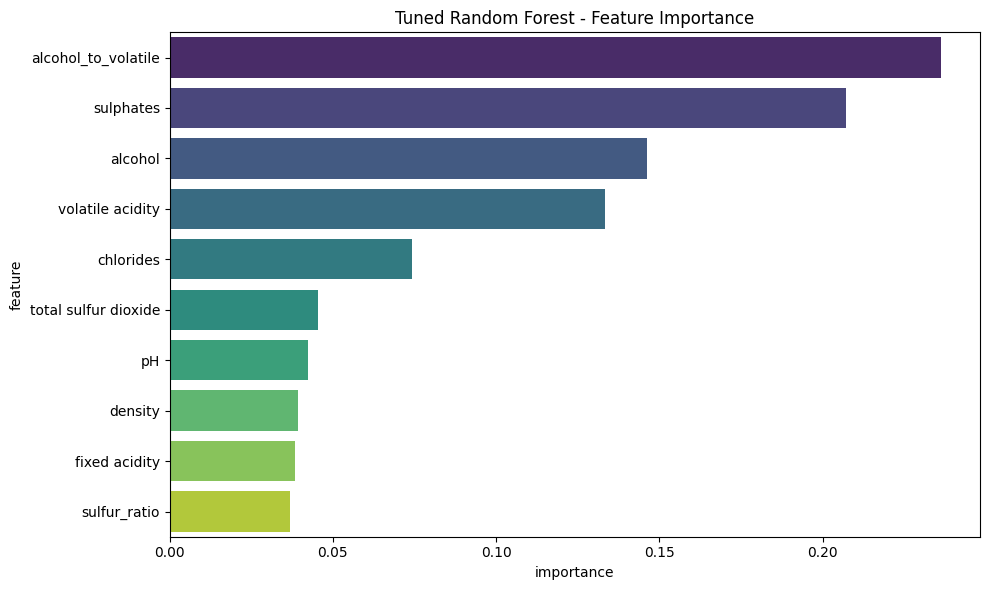

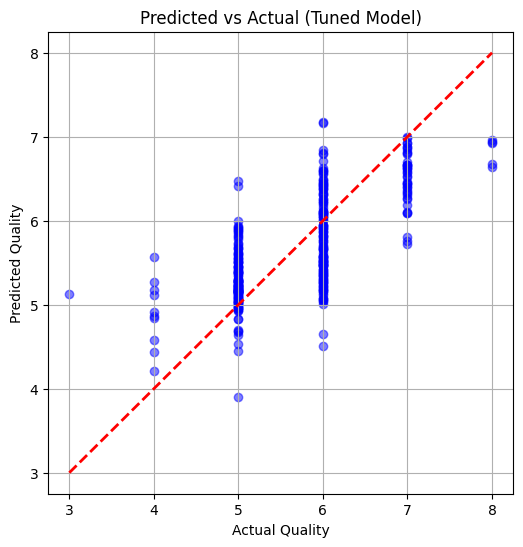

In [46]:
# Feature Engineering
# 기존 df, X_train/X_test가 존재한다고 가정
# 파생 변수 추가
df_eng['alcohol_to_volatile'] = df_eng['alcohol'] / (df_eng['volatile acidity'] + 1e-5)
df_eng['sulfur_ratio'] = df_eng['total sulfur dioxide'] / (df_eng['free sulfur dioxide'] + 1e-5)
# 중요도 낮은 피처 제거
drop_cols = ['citric acid', 'residual sugar', 'free sulfur dioxide']
df_eng = df_eng.drop(columns=drop_cols)

# X, y 업데이트
X_eng = df_eng.drop("quality", axis=1).values
y_eng = df_eng["quality"].values

# train/test split 후 표준화
X_train_eng, X_test_eng, y_train_eng, y_test_eng = train_test_split(
    X_eng, y_eng, test_size=0.2, random_state=42
)

scaler_eng = StandardScaler()
X_train_eng = scaler_eng.fit_transform(X_train_eng)
X_test_eng = scaler_eng.transform(X_test_eng)

# 클래스 불균형 처리
counts = Counter(y_train_eng)
class_weights = {k: 1/v for k, v in counts.items()}
sample_weights = np.array([class_weights[val] for val in y_train_eng])

# Grid Search를 통한 하이퍼파라미터 튜닝
# 탐색할 파라미터 그리드 설정
param_grid = {
    'n_estimators': [100, 300, 500],    # 트리의 개수
    'max_depth': [10, 20, 30, None],    # 트리의 최대 길이
    'min_samples_split': [2, 5, 10],        # 노드 분할을 위한 최소 샘플 수
    'min_samples_leaf': [1, 2, 4],         # 리프 노드에 있어야 할 최소 샘플 수
    'max_features': ['sqrt', 'log2']     # 각 분할에서 고려할 피처의 수
}
"""
param_grid = {
    'n_estimators': [100, 300, 500],    
    'max_depth': [10, 20, 30, None],    
    'min_samples_split': [2, 5, 10],    
    'min_samples_leaf': [1, 2, 4],      
    'max_features': ['sqrt', 'log2']    
}
결과: Fitting 5 folds for each of 216 candidates, totalling 1080 fits최적의 파라미터: 
{'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}
Best CV Score (Negative MSE): -1.3299RMSE: 0.5723, R2: 0.4987
"""


# 기본 모델 정의
rf_base = RandomForestRegressor(random_state=42, n_jobs=-1)

# GridSearchCV 설정
# cv=5: 5-Fold 교차 검증
# scoring='neg_mean_squared_error': MSE 기준으로 최적 모델 선정 (값이 클수록(0에 가까울수록) 좋음)
grid_search = GridSearchCV(
    estimator=rf_base,
    param_grid=param_grid,
    cv=5, 
    n_jobs=-1,
    scoring='neg_mean_squared_error',
    verbose=1
)

# 학습
grid_search.fit(X_train_eng, y_train_eng, sample_weight=sample_weights)
# 최적의 파라미터 출력
print(f"최적의 파라미터: {grid_search.best_params_}")
print(f"Best CV Score (Negative MSE): {grid_search.best_score_: .4f}")
# 최적의 모델 추출
best_rf = grid_search.best_estimator_

# 평가
y_pred_eng = best_rf.predict(X_test_eng)
rmse_eng = np.sqrt(mean_squared_error(y_test_eng, y_pred_eng))
r2_eng = r2_score(y_test_eng, y_pred_eng)
print(f"RMSE: {rmse_eng:.4f}, R2: {r2_eng:.4f}")

# Feature Importance 시각화
feature_names_eng = df_eng.drop("quality", axis=1).columns
importances_eng = best_rf.feature_importances_
importance_df_eng = pd.DataFrame({"feature": feature_names_eng, "importance": importances_eng})
importance_df_eng = importance_df_eng.sort_values("importance", ascending=False).reset_index(drop=True)

plt.figure(figsize=(10,6))
sns.barplot(x="importance", y="feature", data=importance_df_eng, palette="viridis")
plt.title("Tuned Random Forest - Feature Importance")
plt.tight_layout()
plt.show()

# 예측 vs 실제 시각화
plt.figure(figsize=(6,6))
plt.scatter(y_test_eng, y_pred_eng, alpha=0.5, color='blue')
plt.plot([y_test_eng.min(), y_test_eng.max()], [y_test_eng.min(), y_test_eng.max()], 'r--', lw=2)
plt.xlabel("Actual Quality")
plt.ylabel("Predicted Quality")
plt.title("Predicted vs Actual (Tuned Model)")
plt.grid(True)
plt.show()
